1. 以下关于RNN的说法不正确的是：  
   A. RNN的权值更新通过与MLP相同的传统反向传播算法进行计算。  
   B. RNN的中间结果不仅取决于当前的输入还取决于上一步时间的中间结果。    
   C. RNN结构灵活，可以控制输入输出的数目，以针对不同的任务。  
   D. RNN中容易出现梯度消失或梯度爆炸问题，因此很难应用在序列较长的任务上。

答：  
A. 错误。RNN的权值更新使用传统反向传播计算会因为连乘出现梯度爆炸/梯度消失。一般是使用变体的反向传播算法，如GRU、LSTM等。  
B. 正确。RNN正是通过这种设计捕捉到数据的序列关系的。  
C. 正确。RNN的输入输出都可以灵活设置，学习到不同的序列关系，针对不同的任务。  
D. 错误。RNN会因为序列长度产生这些问题，但是通过变体的反向传播和梯度裁剪，可以应用到长序列任务中。

---

2. 以下关于GRU的说法正确的是：   
   A. GRU主要改进了RNN从中间结果到输出之间的结构，可以提升RNN的表达能力。   
   B. GRU相较于一般的RNN更为复杂，但训练反而更加简单。   
   C. 没有一种网络结构可以完整保留过去的所有信息，GRU只是合适的取舍方式。   
   D. 重置门和更新门的输入完全相同，因此可以合并为一个门。  

答：  
A. 正确。GRU通过更新门和重置门来改进中间结果到输出的结构，适当更新和遗忘一些信息，能更好地学习到序列之间的关系，提升了RNN的表达能力。  
B. 正确。GRU的结构比一般的RNN在中间的结构会更加复杂，但是GRU使得参数数量减少了，能更好地梯度下降和学习到序列关系，训练反而更简单了。  
C. 正确。GRU对过去的信息进行取舍，适当更新和重置，捕捉更加重要的序列关系。完整保留过去的所有信息会导致梯度爆炸或梯度消失，模型的参数会非常大，难以训练和保存。  
D. 错误。虽然两个门的输入都包含当前时间步$x_t$和前一时间步$h_{t-1}$，但是两个门的功能是不一样的。重置门是对过去信息$h_{t-1}$选择性遗忘，更新门是控制过去信息和新输入的比例，控制过去信息对当前输入的影响程度。不能简单合并成一个门。

---

3. 在10.3动手实现GRU一节中，根据任务特点，我们用到的RNN的输入输出对应关系是什么？

答：此任务中
- 训练时，输入输出都是相同的形状。输入是一个序列信息，输出是预测的下一个时间段的序列值。
- 测试时，输入是单个值，然后模型预测下一个值再输入预测再下一步的值，最后输出一个时间段的序列值。

---

4. GRU的重置门和更新门，哪个可以维护长期记忆？哪个可以捕捉短期信息？

答：重置门是维护长期记忆的，控制模型对过去信息的保留和遗忘。更新门是捕捉短期信息的，控制整合当前输入和过去信息，发现序列关系。

---

5. 基于本章的代码，调整RNN和GRU的输入序列长度并做同样的训练和测试，观察其模型性能随序列长度的变化情况。

答：测试seq_len=[10,20,30,50]，可以发现，随着序列长度的增加，模型的性能会变差，预测会不准确，而序列长度太短，也同样没有好的模型性能。
- 较短的序列会导致模型拟合局部的序列关系，比如在某个时间段数据是上升的，seq_len=10预测的结果就是整个序列都是上升的。
- 较长的序列会导致模型拟合到过于全局的关系，比如虽然数据是波动的，但是整体而言是一个x轴方向推进的，seq_len=10预测的结果就是序列趋于水平的。

![](https://raw.githubusercontent.com/motewei/DrawingBed/main/img/seq_len10.png)
![](https://raw.githubusercontent.com/motewei/DrawingBed/main/img/seq_len50.png)

---

6. PyTorch中还提供了封装好的LSTM工具`torch.nn.LSTM`，使用方法与GRU类似。将本节代码中的GRU改为LSTM，对比两者的表现。

数据集大小：1000


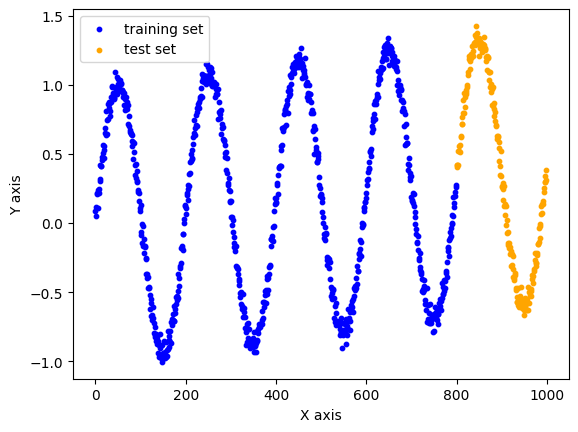

训练序列数：38


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

# 导入数据集
data = np.loadtxt('../sindata_1000.csv', delimiter=',')
num_data = len(data)
split = int(0.8 * num_data)
print(f'数据集大小：{num_data}')
# 数据集可视化
plt.figure()
plt.scatter(np.arange(split), data[:split], 
    color='blue', s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], 
    color='orange', s=10, label='test set')
plt.xlabel('X axis')
plt.ylabel('Y axis')

plt.legend()
plt.show()
# 分割数据集
train_data = np.array(data[:split])
test_data = np.array(data[split:])

# 输入序列长度
seq_len = 20
# 处理训练数据，把切分序列后多余的部分去掉
train_num = len(train_data) // (seq_len + 1) * (seq_len + 1)
train_data = np.array(train_data[:train_num]).reshape(-1, seq_len + 1, 1)
np.random.seed(0)
torch.manual_seed(0)

x_train = train_data[:, :seq_len] # 形状为(num_data, seq_len, input_size)
y_train = train_data[:, 1: seq_len + 1]
print(f'训练序列数：{len(x_train)}')

# 转为PyTorch张量
x_train = torch.from_numpy(x_train).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
x_test = torch.from_numpy(test_data[:-1]).to(torch.float32)
y_test = torch.from_numpy(test_data[1:]).to(torch.float32)

In [116]:
class LSTM(nn.Module):
    # 包含PyTorch的LSTM和拼接的MLP
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        # LSTM模块
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        # 将中间变量映射到预测输出的MLP
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, x, hidden):
        # 前向传播
        # x的维度为(batch_size, seq_len, input_size)
        # LSTM模块接受的输入为(seq_len, batch_size, input_size)
        # 因此需要对x进行变换
        # transpose函数可以交换x的坐标轴
        # out的维度是(seq_len, batch_size, hidden_size)
        out, hidden = self.lstm(torch.transpose(x, 0, 1), hidden) 
        # 取序列最后的中间变量输入给全连接层
        out = self.linear(out.view(-1, self.hidden_size))
        return out, hidden

# 超参数
input_size = 1 # 输入维度
output_size = 1 # 输出维度
hidden_size = 16 # 中间变量维度
learning_rate = 5e-4

# 初始化网络
lstm = LSTM(input_size, output_size, hidden_size)
lstm_optim = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# LSTM测试函数，x和hidden分别是初始的输入和中间变量
def test_lstm(lstm, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        lstm_pred, hidden = lstm(inp, hidden)
        pred.append(lstm_pred.detach())
        inp = lstm_pred
    return torch.cat(pred).reshape(-1)


In [117]:
class GRU(nn.Module):
    # 包含PyTorch的GRU和拼接的MLP
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        # GRU模块
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size) 
        # 将中间变量映射到预测输出的MLP
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        # 前向传播
        # x的维度为(batch_size, seq_len, input_size)
        # GRU模块接受的输入为(seq_len, batch_size, input_size)
        # 因此需要对x进行变换
        # transpose函数可以交换x的坐标轴
        # out的维度是(seq_len, batch_size, hidden_size)
        out, hidden = self.gru(torch.transpose(x, 0, 1), hidden) 
        # 取序列最后的中间变量输入给全连接层
        out = self.linear(out.view(-1, hidden_size))
        return out, hidden
    
# 超参数
input_size = 1 # 输入维度
output_size = 1 # 输出维度
hidden_size = 16 # 中间变量维度
learning_rate = 5e-4

# 初始化网络
gru = GRU(input_size, output_size, hidden_size)
gru_optim = torch.optim.Adam(gru.parameters(), lr=learning_rate)

# GRU测试函数，x和hidden分别是初始的输入和中间变量
def test_gru(gru, x, hidden, pred_steps):
    pred = []
    inp = x.view(-1, input_size)
    for i in range(pred_steps):
        gru_pred, hidden = gru(inp, hidden)
        pred.append(gru_pred.detach())
        inp = gru_pred
    return torch.concat(pred).reshape(-1)

In [118]:
max_epoch = 150
criterion = nn.functional.mse_loss
hidden_gru = None # GRU的中间变量
hidden_lstm = None # LSTM的中间变量

# 训练损失
gru_losses = []
lstm_losses = []
gru_test_losses = []
lstm_test_losses = []

# 开始训练
with tqdm(range(max_epoch)) as pbar:
    for epoch in pbar:
        gru_loss = 0.0
        lstm_loss = 0.0
        
        # 随机梯度下降
        for X, y in zip(x_train, y_train):
            # 更新GRU模型
            if hidden_gru is not None:
                hidden_gru.detach_()
            gru_pred, hidden_gru = gru(X[None, ...], hidden_gru)
            gru_train_loss = criterion(gru_pred.view(y.shape), y)
            gru_optim.zero_grad()
            gru_train_loss.backward()
            gru_optim.step()
            gru_loss += gru_train_loss.item()
            
            # 更新LSTM模型
            if hidden_lstm is not None:
                hidden_lstm = tuple(h.detach() for h in hidden_lstm)
            lstm_pred, hidden_lstm = lstm(X[None, ...], hidden_lstm)
            lstm_train_loss = criterion(lstm_pred, y)
            lstm_optim.zero_grad()
            lstm_train_loss.backward()
            lstm_optim.step()
            lstm_loss += lstm_train_loss.item()
        
        gru_loss /= len(x_train)
        lstm_loss /= len(x_train)
        gru_losses.append(gru_loss)
        lstm_losses.append(lstm_loss)
        
        # 训练和测试时的中间变量序列长度不同，训练时为seq_len，测试时为1
        gru_pred = test_gru(gru, x_test[0], hidden_gru[:, -1], len(y_test))
        lstm_pred = test_lstm(lstm, x_test[0], (hidden_lstm[0][:, -1], hidden_lstm[1][:, -1]), len(y_test))
        gru_test_loss = criterion(gru_pred, y_test).item()
        lstm_test_loss = criterion(lstm_pred, y_test).item()
        gru_test_losses.append(gru_test_loss)
        lstm_test_losses.append(lstm_test_loss)
        
        pbar.set_postfix({
            'Epoch': epoch,
            'GRU loss': f'{gru_loss:.4f}',
            'LSTM loss': f'{lstm_loss:.4f}',
            'GRU test loss': f'{gru_test_loss:.4f}',
            'LSTM test loss': f'{lstm_test_loss:.4f}'
        })

100%|██████████| 150/150 [05:46<00:00,  2.31s/it, Epoch=149, GRU loss=0.0033, LSTM loss=0.0036, GRU test loss=0.0202, LSTM test loss=0.8241]


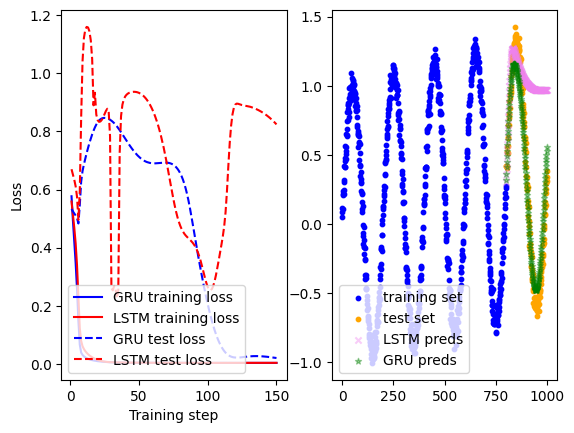

In [119]:
# 最终测试结果
gru_preds = test_gru(gru, x_test[0], hidden_gru[:, -1], len(y_test)).numpy()
lstm_preds = test_lstm(lstm, x_test[0], (hidden_lstm[0][:, -1], hidden_lstm[1][:, -1]), len(y_test)).numpy()

# 绘制训练曲线
plt.subplot(121)
x_plot = np.arange(len(gru_losses)) + 1
plt.plot(x_plot, gru_losses, color='blue', label='GRU training loss')
plt.plot(x_plot, lstm_losses, color='red', label='LSTM training loss')
plt.plot(x_plot, gru_test_losses, color='blue', linestyle='--', label='GRU test loss')
plt.plot(x_plot, lstm_test_losses, color='red', linestyle='--', label='LSTM test loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.legend(loc='lower left')

# 绘制真实数据与模型预测值的图像
plt.subplot(122)
plt.scatter(np.arange(split), data[:split], color='blue', s=10, label='training set')
plt.scatter(np.arange(split, num_data), data[split:], color='orange', s=10, label='test set')
plt.scatter(np.arange(split, num_data - 1), lstm_preds, color='violet', 
    marker='x', alpha=0.4, s=20, label='LSTM preds')
plt.scatter(np.arange(split, num_data - 1), gru_preds, color='green', 
    marker='*', alpha=0.4, s=20, label='GRU preds')
plt.legend(loc='lower left')
plt.show()


可以看到相同参数设置下LSTM的训练效果不好，出现了过拟合的现象。

https://colah.github.io/posts/2015-08-Understanding-LSTMs/